In [1]:
import os
import json
from PIL import Image

from tqdm.notebook import tqdm

import torch
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [2]:
class DigitDataset(data.Dataset):
    def __init__(self, path, train: bool=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")  # path - путь к корневой папке dataset, "train" и "test" - названия папок в структуре для хранения датасета
        self.transform = transform
        with open(os.path.join(path, "format.json"), "r") as fp:
            self.format = json.load(fp)

        self.length = 0
        self.files = []
        self.targets = torch.eye(10)

        for _dir, _target in self.format.items():  # папка и целевое значение
            path = os.path.join(self.path, _dir)  # подключаемся к папке
            list_files = os.listdir(path)  # получаем список файлов в каждом каталоге
            self.length += len(list_files)  # подсчитываем их количесвто
            self.files.extend(map(lambda _x: (os.path.join(path, _x), _target), list_files))  # сопоставляем путь к файлу и целевое значение, записываем это всё в список


    def __getitem__(self, item):
        path_file, target = self.files[item]
        t = self.targets[target]  # тензор one-hot
        img = Image.open(path_file)  # картинка, пока что объект PIL

        if self.transform:
            img = self.transform(img).ravel().float() / 255.0

        return img, t

    def __len__(self):
        return self.length


class RavelTransform(nn.Module):
    def forward(self, item):
        return item.ravel()


class DigitNN(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layers = nn.Sequential()
        self.layers.add_module('layer_1', nn.Linear(input_dim, num_hidden))
        self.layers.add_module('relu', nn.ReLU())
        self.layers.add_module('bn_1', nn.BatchNorm1d(num_hidden))
        self.layers.add_module('layer_2', nn.Linear(num_hidden, output_dim))
    def forward(self, x):
        x = self.layers.forward(x)
        return x

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1313 [00:00<?, ?it/s]

  0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

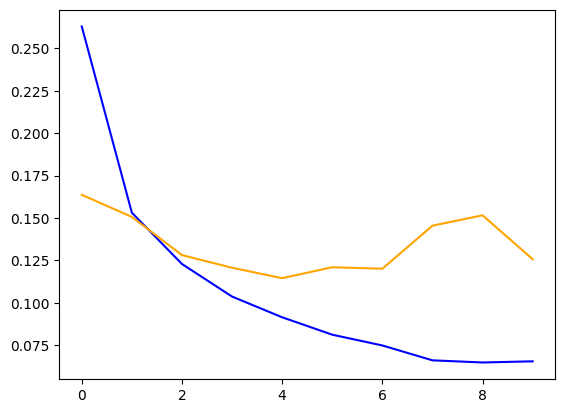

In [3]:
transforms = tfs.Compose([tfs.ToImage(),
                          tfs.ToDtype(torch.uint8),
                         tfs.Grayscale(),
                          tfs.ToDtype(torch.float32, scale=True),
                         RavelTransform()])  # трансформации с данными

dataset_mnist = ImageFolder('dataset/train', transform=transforms)  # прописываем путь уже к конкретному каталогу, а не корневому
d_train, d_val = data.random_split(dataset_mnist, [0.7, 0.3])  # разделяем выделяем в тренировочной выборке проверочную
train_data = data.DataLoader(d_train, batch_size=32, shuffle=True)  # объект-генератор
train_data_val = data.DataLoader(d_val, batch_size=32, shuffle=False)

model = DigitNN(28 * 28, 128, 10)
optimizer = optim.RMSprop(params=model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

epochs = 10
best_loss = 1e10
best_epoch = 0
loss_lst = []
loss_lst_val = []

model_state_dict = {'tfs': transforms.state_dict(),
                   'opt': optimizer.state_dict(),
                   'loss_func': loss_func.state_dict(),
                   'model': model.state_dict()}  # Создаём словарь для сохранения модели

for epoch in range(epochs):
    model.train()
    
    mean_loss = 0
    mean_count = 0
    
    train_tqdm = tqdm(train_data, leave=False)
    
    for x_train, y_train in train_tqdm:
        predict = model.forward(x_train)
        loss = loss_func(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_count += 1
        mean_loss = 1 / mean_count * loss.item() + (1 - 1 / mean_count) * mean_loss
        train_tqdm.set_description(f'Epoch [{epoch + 1}/{epochs}], mean_loss = {mean_loss:.3f}')

    model.eval()  # работаем с проверочной (validation) выборкой

    Q_val = 0
    count_val = 0

    val_tqdm = tqdm(train_data_val, leave=False)
    for x_val, y_val in val_tqdm:
        with torch.no_grad():
            pred = model.forward(x_val)
            loss = loss_func(pred, y_val)
            Q_val += loss.item()
            count_val += 1
            val_tqdm.set_description(f'Epoch [{epoch + 1}/{epochs}], val_loss = {Q_val / len(train_data_val):.3f}')

    Q_val /= count_val
    if best_loss > Q_val:
        best_loss = Q_val
        best_epoch = epoch
        model_state_dict['model'] = model.state_dict()
    loss_lst.append(mean_loss)
    loss_lst_val.append(Q_val)

torch.save(model_state_dict, f'model_dnn_{best_epoch}.tar')


d_test = ImageFolder('dataset/test', transforms)
test_data = data.DataLoader(d_test, batch_size=512, shuffle=False)

model.eval()
total_accuracy = 0

test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model.forward(x_test)
    predict = torch.argmax(predict, dim=1)
    total_accuracy += torch.sum(predict == y_test).item()

    test_tqdm.set_description(f'total_accuracy = {total_accuracy / len(d_test)}') 


plt.plot(loss_lst, color='blue', label='loss_train')
plt.plot(loss_lst_val, color='orange', label='loss_val')